# Imports


In [1]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

2024-01-09 00:37:14.550478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 00:37:14.652688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 00:37:14.652742: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 00:37:14.652792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 00:37:14.666831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 00:37:14.667948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Creating and annotating a dataset

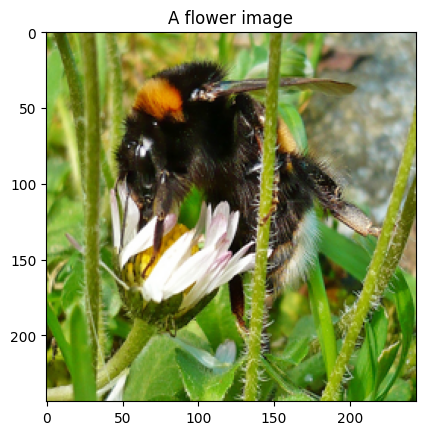

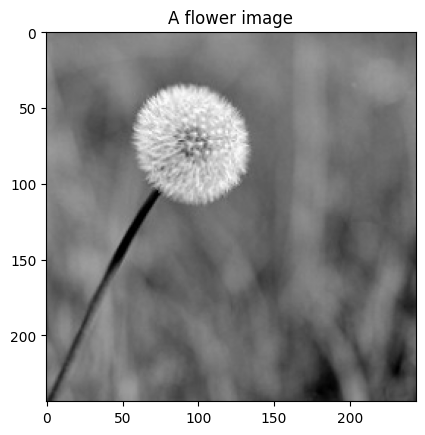

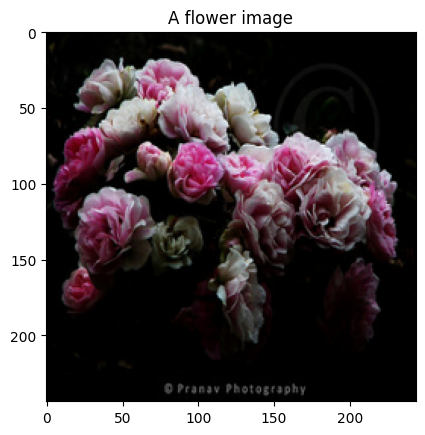

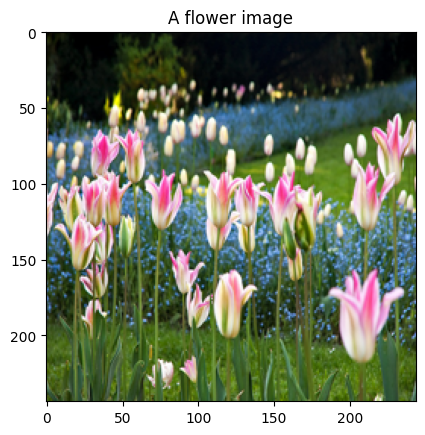

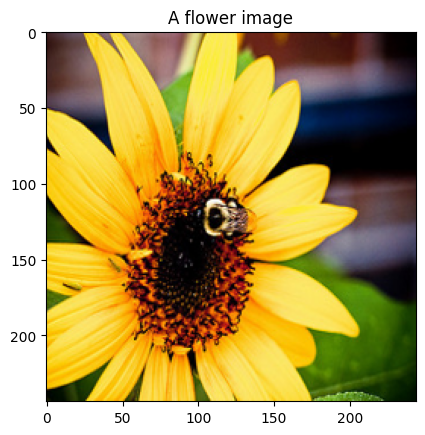

Dataset elements specification: (TensorSpec(shape=(244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [3]:
class_mapping = {"daisy": 0,
                 "dandelion": 1,
                 "rose": 2,
                 "sunflower": 3,
                 "tulip": 4}

def create_dataset(img_dir: str,
                   target_size: tuple =(244,244),
                   visualize: bool = False):
    """ Create a tensorlflow dataset from images saved
        in a local diretory """

    image_files = os.listdir(img_dir)

    # Naive way of annotating
    labels = [img.replace(".jpg","") for img in image_files]
    image_tensors = []

    for img in image_files:
        img_path = os.path.join(img_dir, img)
        img = Image.open(img_path)
        img = img.resize(target_size)

        # Visualize the images
        if visualize:
            plt.imshow(img)
            plt.title('A flower image')
            plt.show()

        # Pre-process images for tensorflow
        img_array = np.array(img) / 255.0
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        image_tensors.append(img_tensor)

    # Create integer class annotations for all the images    
    labels = [class_mapping[label] for label in labels]
    labels = tf.convert_to_tensor(labels, dtype= tf.int32)
        
    # Create a Tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_tensors, labels))

    # Print detailed specification of dataset elements
    print("Dataset elements specification:", dataset.element_spec)

    return dataset


dataset = create_dataset('images/', visualize = True)

# Iterate the dataset and verify data

In [24]:
for image,label in dataset.take(1):
    print("Image shape:", image.shape)
    print("Image type:",type(image))
    print("Label:", label.numpy()) 

Image shape: (244, 244, 3)
Image type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Label: 1
tf.Tensor(1, shape=(), dtype=int32)


# A simple linear model for image classification
![Alt text](linear_model.png "A simple linear model")

Fig. 1: A simple linear model applied over an RGB image

In [97]:
# How does a simple linear model can be defined using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(244,244,3)),
    tf.keras.layers.Dense(units=5, activation="softmax")
])

# Compile a model with an optimizer,loss function and some metric
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


# Train the model
model.fit(dataset.batch(1), epochs=5)


# Create a testing set
test_set = create_dataset('test_images/', visualize = False)

# Run some predictions over our dataset
all_predictions = []
all_confidences = []
all_ground_truths = []


# Initialize an empty PrettyTable
results_table = PrettyTable()

# Define table headers
results_table.field_names = ["True Class", "Predicted Class", "Confidence(%)", ]


# Iterate through the dataset
for image, label in test_set:
    # Make a prediction
    prediction = model(tf.expand_dims(image, axis=0))

    pred_idx = tf.argmax(prediction, axis=1)

    for key, value in class_mapping.items():
        if value == pred_idx:
            confidence = prediction.numpy()[0][pred_idx]
            all_predictions.append(value)
            all_confidences.append(round(confidence[0] * 100,2))
            all_ground_truths.append(label)

# Print predictions and confidences for all images
for predicted_class, confidence, true_label in zip(all_predictions, all_confidences, all_ground_truths):
    results_table.add_row([true_label.numpy(), predicted_class, confidence])

print(results_table)
print(f'Model Accuracy on test set: {model.evaluate(test_set.batch(1), verbose = 0)[1]: .4f}')

Epoch 1/5
5/5 [==============================] - 1s 14ms/step - loss: 126.1631 - accuracy: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 8.3058 - accuracy: 0.4000
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 13.8037 - accuracy: 0.6000
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 2.6514 - accuracy: 0.8000
Epoch 5/5
5/5 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Dataset elements specification: (TensorSpec(shape=(244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
+------------+-----------------+---------------+
| True Class | Predicted Class | Confidence(%) |
+------------+-----------------+---------------+
|     1      |        1        |     100.0     |
|     2      |        2        |     98.89     |
|     4      |        2        |     85.01     |
+------------+-----------------+---------------+
Model Accuracy on test

# The Convolutional Neural Network (CNN)

<img src="https://miro.medium.com/v2/resize:fit:2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif" alt="The art of Convolution" width="640" height="480">

Fig. 2 : Illustration of the convolution operation (source: <a href="https://miro.medium.com/v2/resize:fit:2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif">link</a>)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

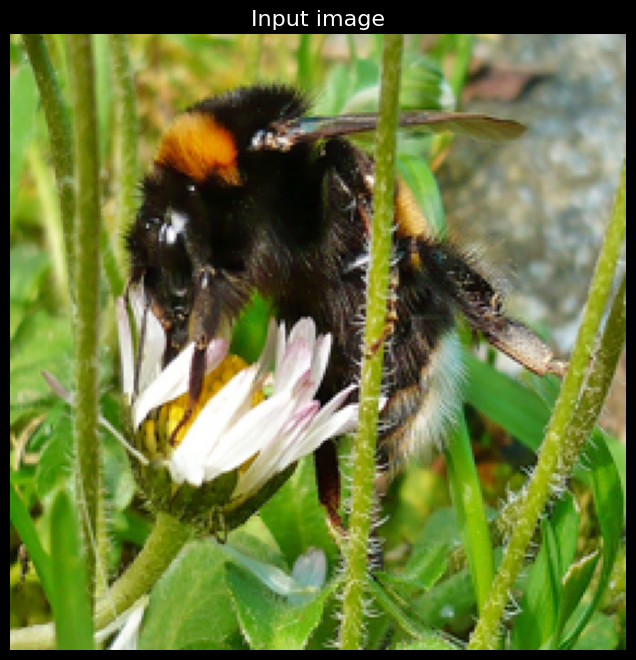

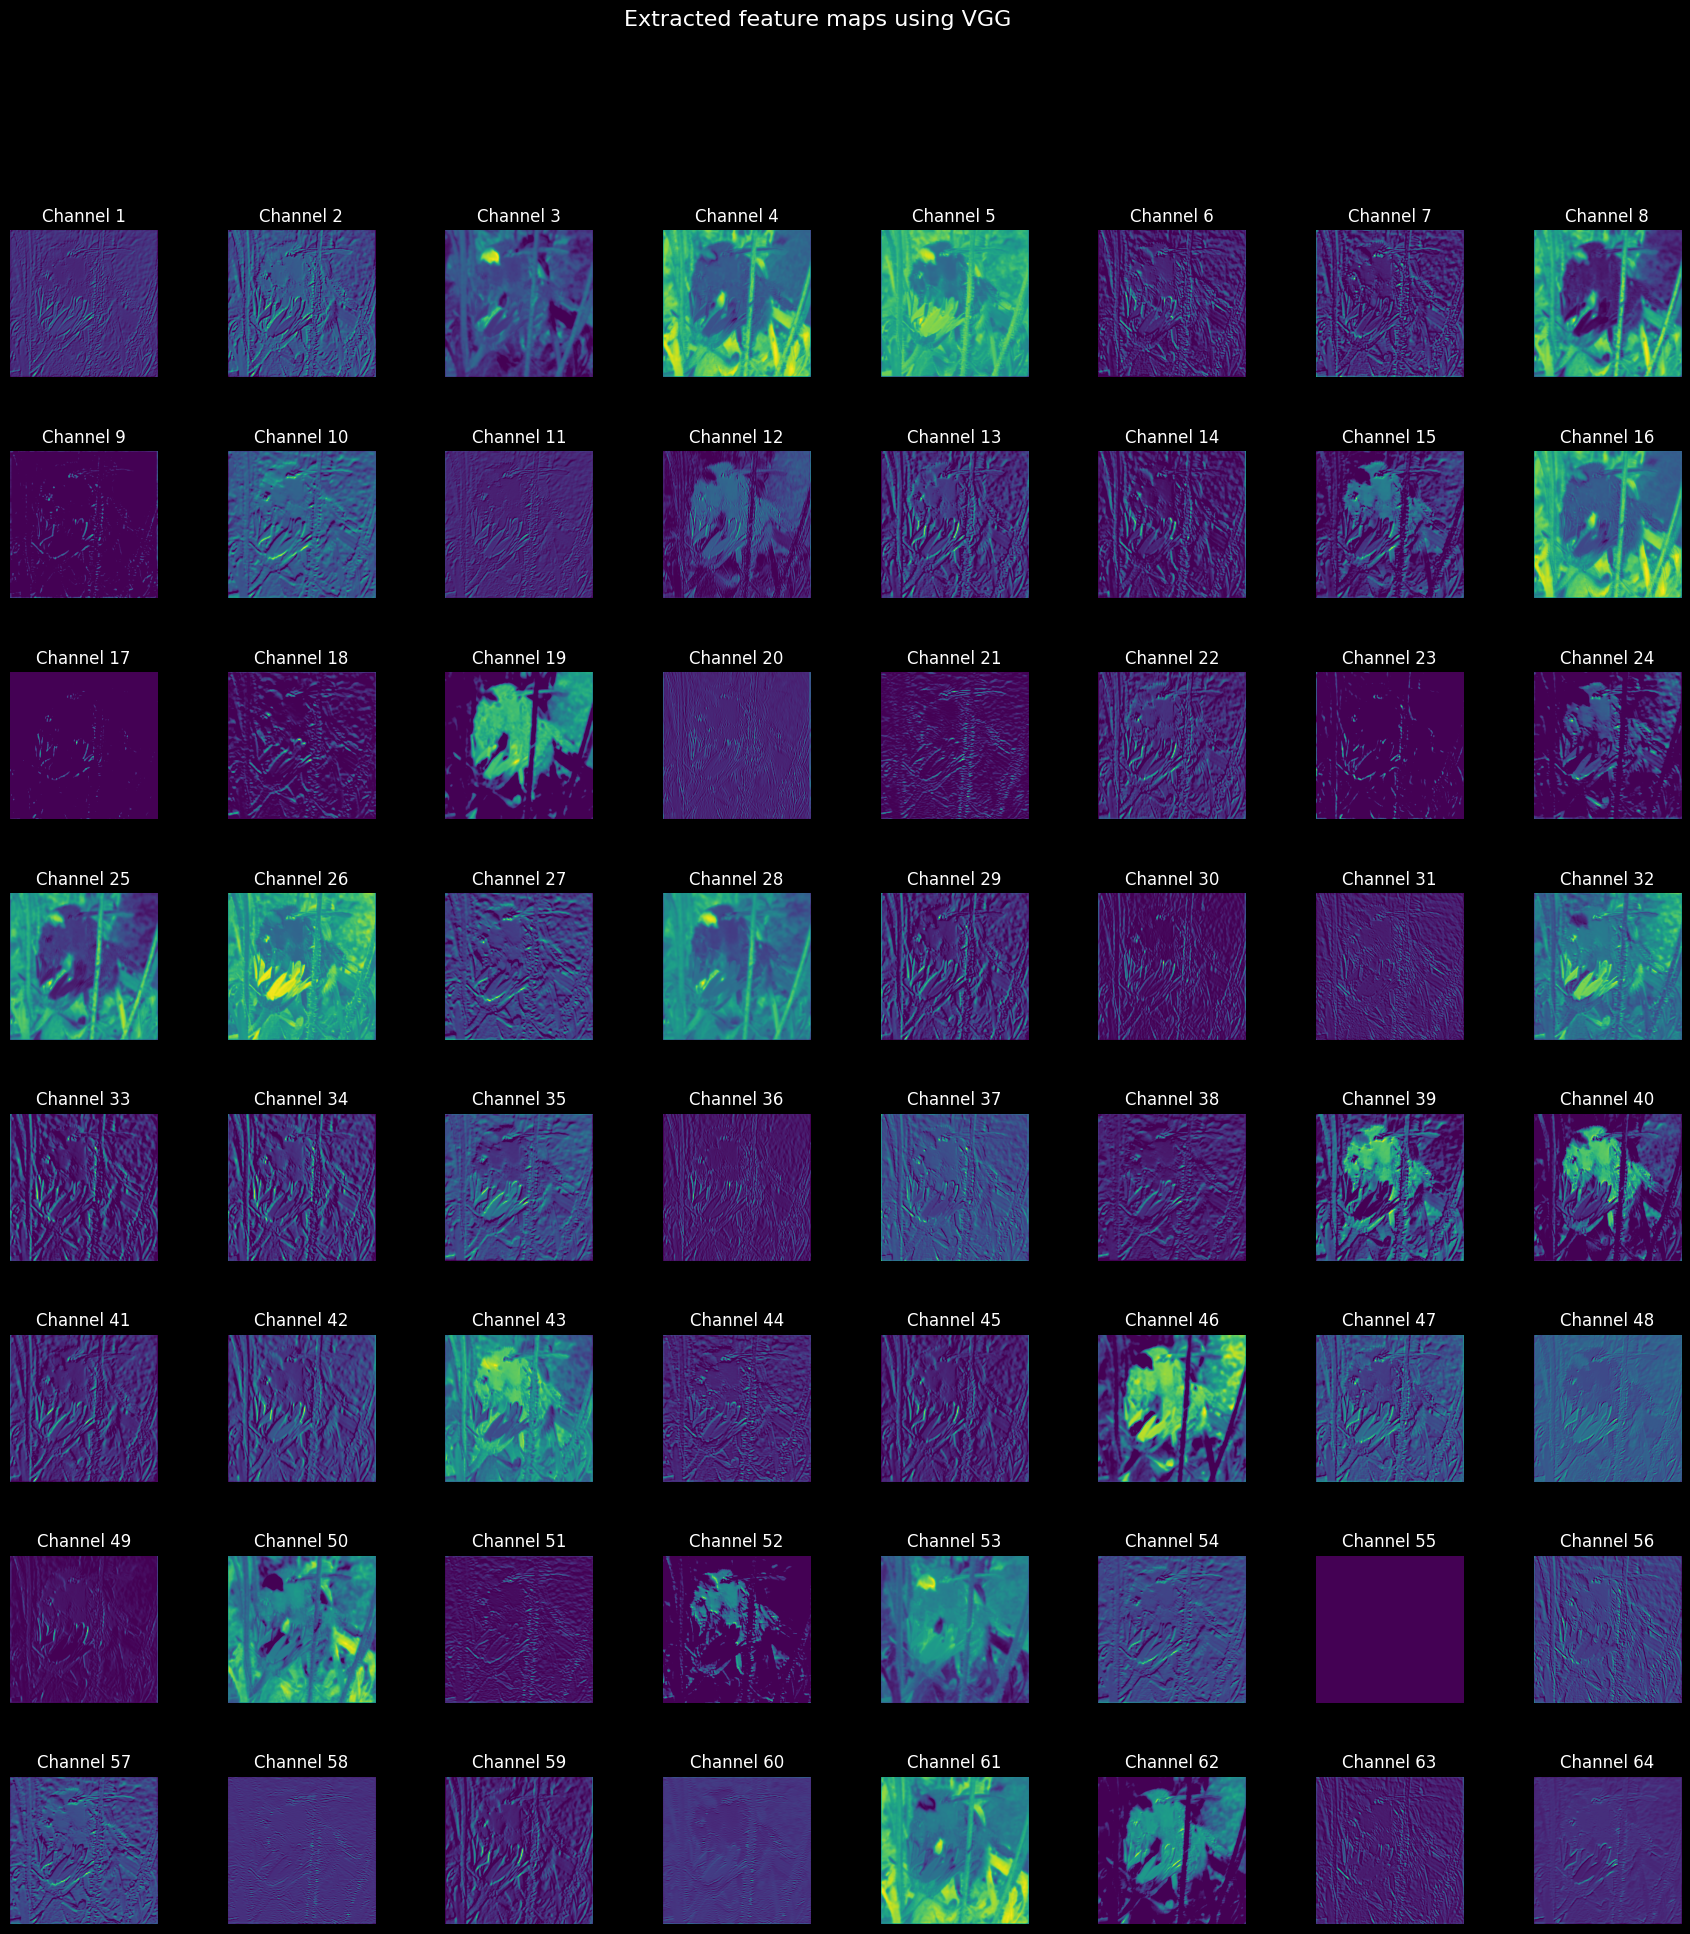

In [17]:
# Load the pre-trained VGG convolutional feature extractor model 
base_model = VGG16(weights='imagenet', include_top=False)
print(base_model.summary())
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv2').output)  

# Take a sample image
image,_ = next(iter(dataset))

# Plot the image
plt.figure(figsize=(8, 8))
plt.title("Input image",color='white', fontsize=16) 
plt.imshow(image.numpy())
plt.axis('off')
plt.show()


# Get the predicted feature maps
feature_maps = model.predict(tf.expand_dims(image,axis = 0), verbose = 0)

# Visualize the feature maps
plt.figure(figsize=(22, 22))
for i in range(64):  # Change this number depending on the number of filters in the selected layer you want to visualize
    plt.subplot(8, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis') 
    plt.title(f'Channel {i+1}', color = 'white')
    plt.axis('off')


plt.subplots_adjust(hspace=0.5)
plt.style.use('dark_background')
plt.suptitle("Extracted feature maps using VGG", color='white', fontsize=16) 
plt.show()


### General notes on Convolutional Neural Networks
##### Shallow layers
1. Extract basic features like edges, textures, and simple shapes.
2. These layers capture simple fine-grained (low level) details in the input image.
3. The filters in these layers are relatively small and can be trained to detect simple patterns.

##### Deeper layers
1. Extract more complex and abstract features.
2. Detect recognizable patterns and object representations.
3. The filters in these layers capture more meaningful semantic information for the end task.

# Data Augmentations

Data augmentations are essential in training vision models as they introduce diversity to the dataset, enhancing the model's ability to generalize. By applying transformations like rotations, flips, and others to training images, augmentations reduce overfitting and enable models to perform better on various real-world scenarios and data variations, leading to improved accuracy in computer vision tasks.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


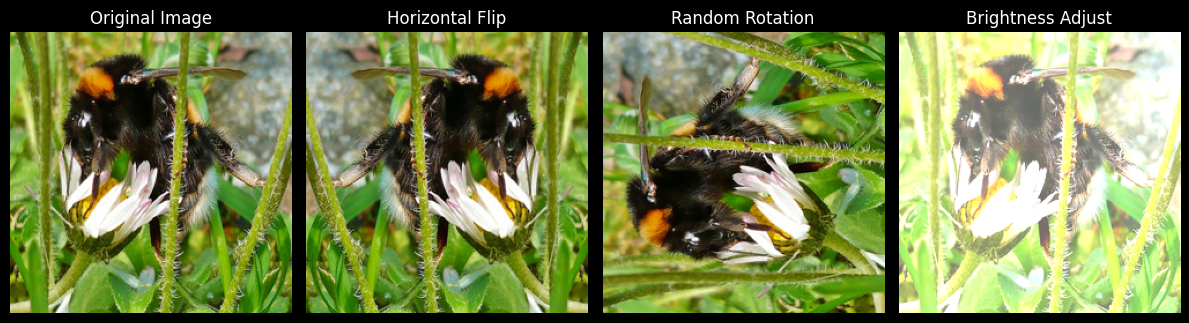

In [52]:
# Plot original image
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(image.numpy())
plt.title('Original Image')
plt.axis('off')

# Define three different augmentations
augmented_images = []
titles = ['Horizontal Flip', 'Random Rotation', 'Brightness Adjust']

# Augmentation 1: Horizontal Flip
augmented_img1 = tf.image.random_flip_left_right(image)
augmented_images.append(augmented_img1)

# Augmentation 2: Rotation (Fixed at 90 degrees)
rotation_angle = 90.0
augmented_img2 = tf.image.rot90(image, k=tf.cast(rotation_angle / 90, tf.int32))
augmented_images.append(augmented_img2)

# Augmentation 3: Brightness Adjustment (do this within a reasonable range)
brightness_factor = tf.random.uniform(shape=[], minval=0.4, maxval=0.8, dtype=tf.float32)
augmented_img3 = tf.image.adjust_brightness(image, brightness_factor)
augmented_images.append(augmented_img3)

# Plot the augmented images
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(1, 4, i + 2)
    plt.imshow(augmented_img)
    plt.title(f'{titles[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()